In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from datetime import datetime

In [9]:
shark_data = pd.read_excel("GSAF5.xlxs")

# Dropping unnecessary columns
columns_to_drop = ["href formula", "Case Number", "Case Number.1", "Source", "pdf", "href", "original order", "Unnamed: 21", "Unnamed: 11", "Unnamed: 22"]
shark_data.drop(columns=columns_to_drop, axis=1, inplace=True)

# Dropping rows where all elements are NaN
shark_data.dropna(axis=0, how="all", inplace=True)

# Displaying rows with missing 'Year' values for inspection
shark_data_missing_year = shark_data[shark_data["Year"].isnull()]

In [10]:
#The df with the first changes!
shark_data.head()

,Date,Year,Type,Country,State,Location,Activity,Name,Sex,Age,Injury,Time,Species
0,15 Mar 2024,2024.0,Unprovoked,AUSTRALIA,Queensland,Bargara Beach,Swimming,Brooklyn Sauer,F,13,"Minor injuries to back, abdomen and legs",16h00,Tiger shark
1,04 Mar 2024,2024.0,Unprovoked,USA,Hawaii,"Old Man's, Waikiki",Surfing,Matthew White,M,NaN,"No injury, shark bit surfboard",NaN,Tiger shark 8'
2,02 Mar-2024,2024.0,Unprovoked,USA,Hawaii,"Rainbows, Oahu",Swimming,NaN,F,11,Lacerations to left foot,13h30,3' to 4' shark
3,25 Feb-2024,2024.0,Unprovoked,AUSTRALIA,Western Australia,"Sandlnd Island, Jurian Bay",NaN,female,F,46,Leg bitten,11h30,Tiger shark
4,14 Feb-2024,2024.0,Unprovoked,INDIA,Maharashtra,"Vaitarna River, Palghar District",Fishing,Vicky Suresh Govari,M,32,Calf of lower left leg injured,NaN,"Bull shark, 7'"


In [11]:
# Checking for missing values in the dataset
missing_values = shark_data.isnull().sum()
missing_values

Date           0
Year           2
Type          18
Country       50
State        482
Location     565
Activity     586
Name         220
Sex          579
Age         2994
Injury        35
Time        3526
Species     3132
dtype: int64

In [12]:
# Converting the 'Date' column to datetime format
shark_data['Date'] = pd.to_datetime(shark_data['Date'], errors='coerce')

# Extracting the year from the 'Date' column if 'Year' is missing
shark_data['Year'] = shark_data['Year'].fillna(shark_data['Date'].dt.year)

# Verifying that all 'Year' values are now filled
shark_data['Year'].isnull().sum()

np.int64(2)

In [13]:
#Defining a function to clean and standardize the 'Sex' column
def clean_sex(sex):
    if isinstance(sex, str):
        sex = sex.strip().upper()
        if sex in ['M', 'F']:
            return sex
    return np.nan

shark_data['Sex'] = shark_data['Sex'].apply(clean_sex)

In [14]:
#For the 'Age' column, we will replace empty cells with  the median age
shark_data['Age'] = pd.to_numeric(shark_data['Age'], errors='coerce')
median_age = shark_data['Age'].median()
shark_data['Age'].fillna(median_age, inplace=True)

# Verifying the 'Age' column
shark_data['Age'].describe()

/var/folders/m3/cvmhd4j11f7968wyg9z4qfdr0000gn/T/ipykernel_1133/2259104444.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  shark_data['Age'].fillna(median_age, inplace=True)


count    6944.000000
mean       26.222926
std        10.970630
min         1.000000
25%        22.000000
50%        24.000000
75%        26.000000
max        87.000000
Name: Age, dtype: float64

In [40]:
# Defining the rest of the functions to clean the columns:

def get_hemisphere(country):
    hn_list = ['MEXICO', 'EGYPT', 'BAHAMAS', 'USA', 'SPAIN']
    return "HN" if country in hn_list else "NN"



def convert_date(date_str):
    if pd.isna(date_str) or not isinstance(date_str, str) or len(date_str) != 11:
        return np.nan
    month_dict = {"jan": 1, "feb": 2, "mar": 3, "apr": 4, "may": 5, "jun": 6, "jul": 7, "aug": 8, "sep": 9, "oct": 10, "nov": 11, "dec": 12}
    month = month_dict.get(date_str[3:6].lower(), np.nan)
    if not (date_str[7:11].isdigit() and date_str[0:2].isdigit() and month):
        return np.nan
    try:
        return datetime(int(date_str[7:11]), month, int(date_str[0:2]))
    except:
        return np.nan
    


def convert_codmes(date_str):
    if pd.isna(date_str) or not isinstance(date_str, str) or len(date_str) != 11:
        return np.nan
    month_dict = {"jan": "01", "feb": "02", "mar": "03", "apr": "04", "may": "05", "jun": "06", "jul": "07", "aug": "08", "sep": "09", "oct": "10", "nov": "11", "dec": "12"}
    month = month_dict.get(date_str[3:6].lower(), np.nan)
    return f"{date_str[7:11]}_{month}" if month else np.nan



def convert_sex(sex):
    return sex.strip().upper() if isinstance(sex, str) and sex.strip().upper() in ["M", "F"] else np.nan



def convert_time(time_str):
    if pd.isna(time_str) or not isinstance(time_str, str) or len(time_str) != 5 or time_str[2] != 'h':
        return np.nan
    hours, minutes = time_str.split('h')
    return int(hours) * 60 + int(minutes) if hours.isdigit() and minutes.isdigit() else np.nan



def convert_age(age):
    return int(age) if isinstance(age, str) and age.isdigit() else np.nan



def get_category(activity: str):
    activity_eq = {
        "diving": ["dive", "diving", "snorkel", "clamm", "scuba"],
        "fishing": ["fish", "finn", "spear"],
        "swimming": ["swim", "bath", "wad", "splash", "jump", "float"],
        "surfing": ["surf", "board"],
        "sailing": ["boat", "kayak", "canoe", "cruising", "ship"]
    }

    activity = str(activity).lower()

    for activity_category, activity_keywords in activity_eq.items():
        for keyword in activity_keywords:
            if re.search(rf"\b{keyword}\b", activity):
                return activity_category

    return "other/undefined"



country_groups = {
    'ASIA': ['ASIA?'],
    'ST. MARTIN': ['ST. MAARTIN'],
    'SAMOA': ['WESTERN SOMOA'],
    'MEXICO': ['Mexico', 'MeXICO'],
    'AUSTRALIA': ['Coral Sea'],
    'TURKS AND CAICOS ISLANDS': ['TURKS and CaICOS', 'TURKS & CAICOS'],
    'MALDIVES': ['Maldives', 'MALDIVE ISLANDS'],
    'SOUTH AFRICA': ['South Africa'],
    'COLOMBIA': ['COLUMBIA'],
    'NEW ZEALAND': ['New Zealand'],
    'SAINT KITTS AND NEVIS': ['ST KITTS / NEVIS', 'NEVIS'],
    'SAINT MARTIN': ['ST MARTIN', 'ST. MAARTIN'],
    'REUNION ISLAND': ['REUNION'],
    'UNITED KINGDOM': ['ENGLAND', 'SCOTLAND'],
    'FIJI': ['Fiji'],
    'ANTIGUA AND BARBUDA': ['ANTIGUA'],
    'UNITED ARAB EMIRATES': ['UNITED ARAB EMIRATES (UAE)'],
    'SIERRA LEONE': ['Sierra Leone'],
    'CAYMAN ISLANDS': ['GRAND CAYMAN'],
    'SEYCHELLES': ['Seychelles'],
    'JAPAN': ['OKINAWA'],
    'EGYPT': ['EGYPT / ISRAEL'],
    'CHINA': ['HONG KONG', 'SOUTH CHINA SEA'],
    'SAMOA': ['WESTERN SAMOA', 'AMERICAN SAMOA'],
    'BRITISH VIRGIN ISLANDS': ['BRITISH ISLES'],
    'MICRONESIA': ['FEDERATED STATES OF MICRONESIA'],
    'ANDAMAN AND NICOBAR ISLANDS': ['ANDAMAN / NICOBAR ISLANDAS'],
    'BALKANS': ['THE BALKANS'],
    'SUDAN': ['SUDAN?'],
    'BES ISLANDS': ['NETHERLANDS ANTILLES'],
    'INDONESIA': ['JAVA'],
    'SOLOMON ISLANDS': ['SOLOMON ISLANDS / VANUATU'],
    'DOMINICAN REPUBLIC': ['SAN DOMINGO'],
    'GREECE': ['CRETE'],
    'MYANMAR': ['BURMA'],
    'PAPUA NEW GUINEA': ['BRITISH NEW GUINEA'],
    'SRI LANKA': ['CEYLON', 'CEYLON (SRI LANKA)'],
    'CAMEROON': ['EQUATORIAL GUINEA / CAMEROON'],
    'TRINIDAD AND TOBAGO': ["TOBAGO", 'TRINIDAD', 'TRINIDAD & TOBAGO'],
    'SOUTH KOREA': ['KOREA']
}

for country, incorrect_list in country_groups.items():
    for incorrect in incorrect_list:
        shark_data['Country'].replace(incorrect, country, inplace=True)



def remove_invalid_countries(country):
    invalid_countries = [
        "British Overseas Territory", "nan", "ST HELENA British", "ATLANTIC OCEAN", "PALESTINIAN TERRITORIES",
        "SOUTH PACIFIC OCEAN", "MID ATLANTIC OCEAN", "PERSIAN GULF", "RED SEA / INDIAN OCEAN", "NORTH SEA",
        "INDIAN OCEAN", "AFRICA", "Coast of AFRICA", "TASMAN SEA", "MEDITERRANEAN SEA", "Between PORTUGAL & INDIA",
        "RED SEA?", "ASIA", "GULF OF ADEN", "CARIBBEAN SEA", "NORTHEN ARABIAN SEA", "NORTH ATLANTIC SEA",
        "PACIFIC OCEAN", "IRAN / IRAQ", "CENTRAL PACIFIC", "SOUTH WEST PACIFIC OCEAN", "BAY OF BENGAL",
        "MID-PACIFIC OCEAN", "ITALY / CROATIA", "WEST INDIES", "OCEAN"
    ]
    return np.nan if country in invalid_countries else country



def convert_species(species):
    if not isinstance(species, str):
        return np.nan
    
    species = species.lower()

    size_dict = {
        "big shark": ["big", "7'", "8'", "9'", "10'", "11'", "12'", "13'", "14'", "2 m", "3 m", "4 m", "5 m"],
        "medium shark": ["medium", "4'", "5'", "6'"],
        "small shark": ["small", "1'", "2'", "3'"]
    }

    species_dict = {
        "white": "white shark",
        "not confirmed": "not confirmed",
        "unconfirmed": "not confirmed",
        "questionable": "not confirmed",
        "tiger": "tiger shark",
        "bull": "bull shark",
        "blue": "blue shark",
        "mako": "mako shark",
        "nurse": "nurse shark",
        "wobbegong": "wobbegong shark",
        "blacktip": "blacktip shark"
    }

    for key, value in species_dict.items():
        if key in species:
            return value

    for label, keywords in size_dict.items():
        for keyword in keywords:
            if re.search(rf"\b{keyword}\b", species):
                return label

    if "shark" in species:
        return "other types"
    
    return np.nan


def convert_injury(injury):
    if not isinstance(injury, str):
        return np.nan
    
    injury = injury.lower()
    
    if "no injury" in injury:
        return "no injury"
    if "minor" in injury:
        return "minor injury"
    if "injury" in injury:
        return "injury"
    if "board b" in injury:
        return "board bitten"
    if "bitten" in injury:
        return "bitten"
    if "fatal" in injury:
        return "fatal"
    if "lacerat" in injury:
        return "Lacerated"
    if "survived" in injury:
        return "survived"
    if "severed" in injury:
        return "severed"
    
    return np.nan



def classify_inj(injury):
    injury = str(injury).lower()
    if "fatal" in injury or "bitten" in injury or "injury" in injury:
        return "severe injury"
    if "lacerated" in injury or "no injury" in injury or "minor injury" in injury or "board bitten" in injury or "survived" in injury:
        return "minor injury"
    return np.nan


def get_blood_index(dimension):
    """
    Calculate the blood index for the given dimension.
    
    The blood index is defined as the ratio of severe injuries to minor injuries,
    considering only dimensions with more than 10 total incidents and at least 1 minor injury.
    """
    crosstab = pd.crosstab(shark_data[dimension], shark_data["Injury Severity"])
    crosstab["blood_index"] = crosstab["severe injury"] / crosstab["minor injury"]

    crosstab_filtered = crosstab[(crosstab["minor injury"] > 0) & 
                        ((crosstab["severe injury"] + crosstab["minor injury"]) > 10)]
    return crosstab_filtered.sort_values(by="blood_index", ascending=False)

/var/folders/m3/cvmhd4j11f7968wyg9z4qfdr0000gn/T/ipykernel_1133/2991250640.py:115: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  shark_data['Country'].replace(incorrect, country, inplace=True)


In [39]:
#Calling all the cleaning functions:
shark_data['Hemisphere'] = shark_data['Country'].apply(get_hemisphere)
shark_data['Date'] = shark_data['Date'].apply(convert_date)
shark_data['CodMes'] = shark_data['Date'].apply(convert_codmes)
shark_data['Sex'] = shark_data['Sex'].apply(convert_sex)
shark_data['Time'] = shark_data['Time'].apply(convert_time)
shark_data['Age'] = shark_data['Age'].apply(convert_age)
shark_data['Activity Category'] = shark_data['Activity'].apply(get_category)
shark_data['Country'] = shark_data['Country'].apply(remove_invalid_countries)
shark_data['Injury Category'] = shark_data['Injury'].apply(convert_injury)
shark_data['Injury Severity'] = shark_data['Injury'].apply(classify_inj)
shark_data['Species Category'] = shark_data['Species '].apply(convert_species)

In [78]:
# Filter the data for years after 2004 and in the northern hemisphere
data_target = shark_data[(shark_data["Year"] > 2004) & (shark_data["Hemisphere"] == "NN")]

print(data_target["Year"].value_counts().sort_index(ascending=True))
print(data_target["Year"].value_counts().sum())

data_target["new_date"] = pd.to_datetime(data_target["Date"])
data_target["month"] = data_target["new_date"].dt.month

Year
2005.0    50
2006.0    45
2007.0    42
2008.0    51
2009.0    72
2010.0    50
2011.0    71
2012.0    49
2013.0    52
2014.0    54
2015.0    63
2016.0    57
2017.0    56
2018.0    68
2019.0    47
2020.0    45
2021.0    52
2022.0    39
2023.0    47
2024.0     7
Name: count, dtype: int64
1017


/var/folders/m3/cvmhd4j11f7968wyg9z4qfdr0000gn/T/ipykernel_1133/1364163816.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_target["new_date"] = pd.to_datetime(data_target["Date"])
/var/folders/m3/cvmhd4j11f7968wyg9z4qfdr0000gn/T/ipykernel_1133/1364163816.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_target["month"] = data_target["new_date"].dt.month


/var/folders/m3/cvmhd4j11f7968wyg9z4qfdr0000gn/T/ipykernel_1133/792714847.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data_target, x='Year', palette='pastel')


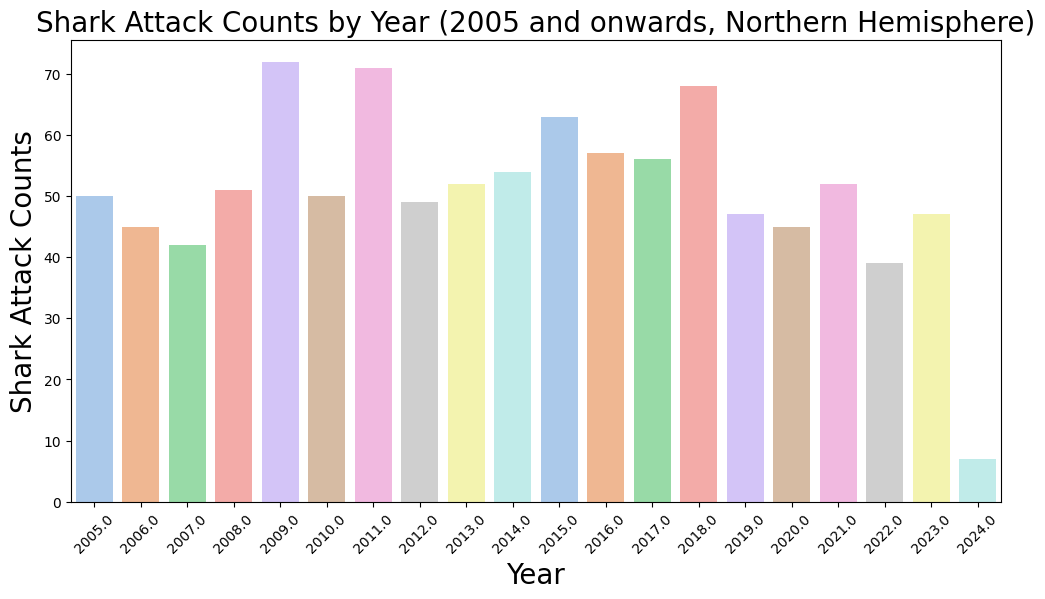

In [81]:
# Plotting shark attacks by year:
plt.figure(figsize=(12, 6))
sns.countplot(data=data_target, x='Year', palette='pastel')
plt.ylabel("Shark Attack Counts", fontsize=20)
plt.xlabel("Year", fontsize=20)
plt.title("Shark Attack Counts by Year (2005 and onwards, Northern Hemisphere)", fontsize=20)
plt.xticks(rotation=45)
plt.show()

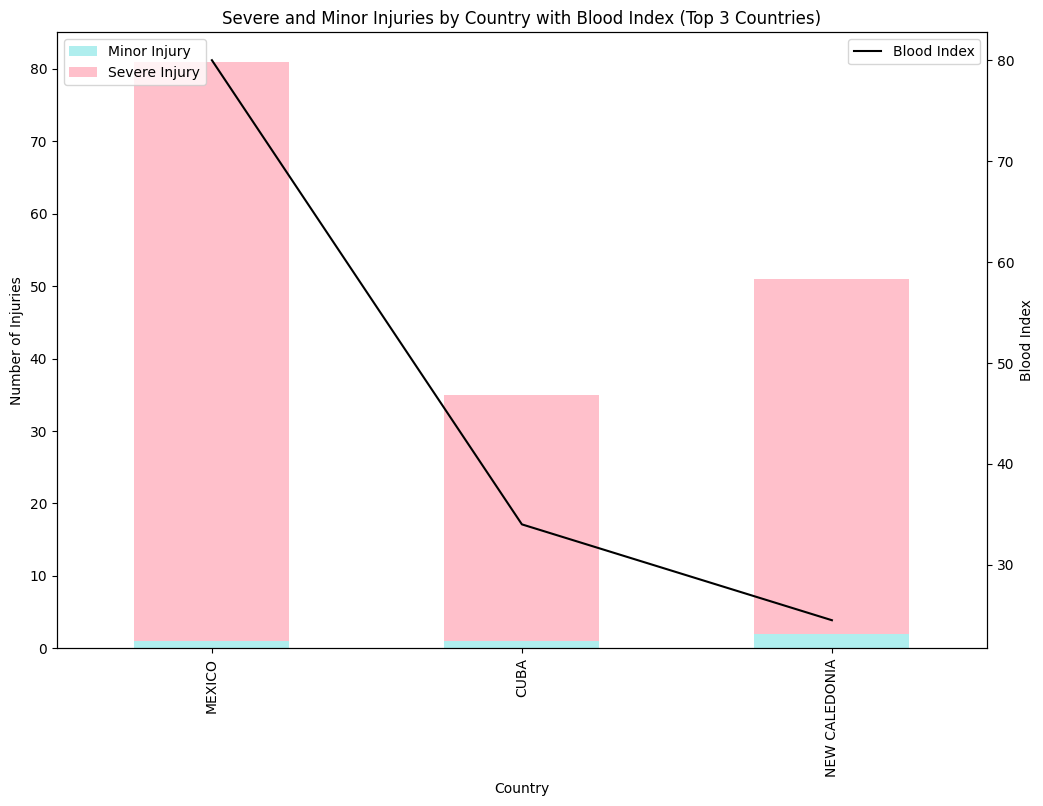

In [49]:
# Calculating blood index by country
blood_index_by_country = get_blood_index("Country")
# Select the top 3 countries
top_3_blood_index_countries = blood_index_by_country.head(3)

fig, ax1 = plt.subplots(figsize=(12, 8))

top_3_blood_index_countries.reset_index().plot(kind='bar', x='Country', y='minor injury', ax=ax1, color='paleturquoise', label='Minor Injury')
top_3_blood_index_countries.reset_index().plot(kind='bar', x='Country', y='severe injury', ax=ax1, color='pink', label='Severe Injury', bottom=top_3_blood_index_countries['minor injury'])

ax2 = ax1.twinx()
ax2.plot(top_3_blood_index_countries.index, top_3_blood_index_countries['blood_index'], label='Blood Index', color='black')

ax1.set_ylabel('Number of Injuries')
ax1.set_title('Severe and Minor Injuries by Country with Blood Index (Top 3 Countries)')
ax2.set_ylabel('Blood Index')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

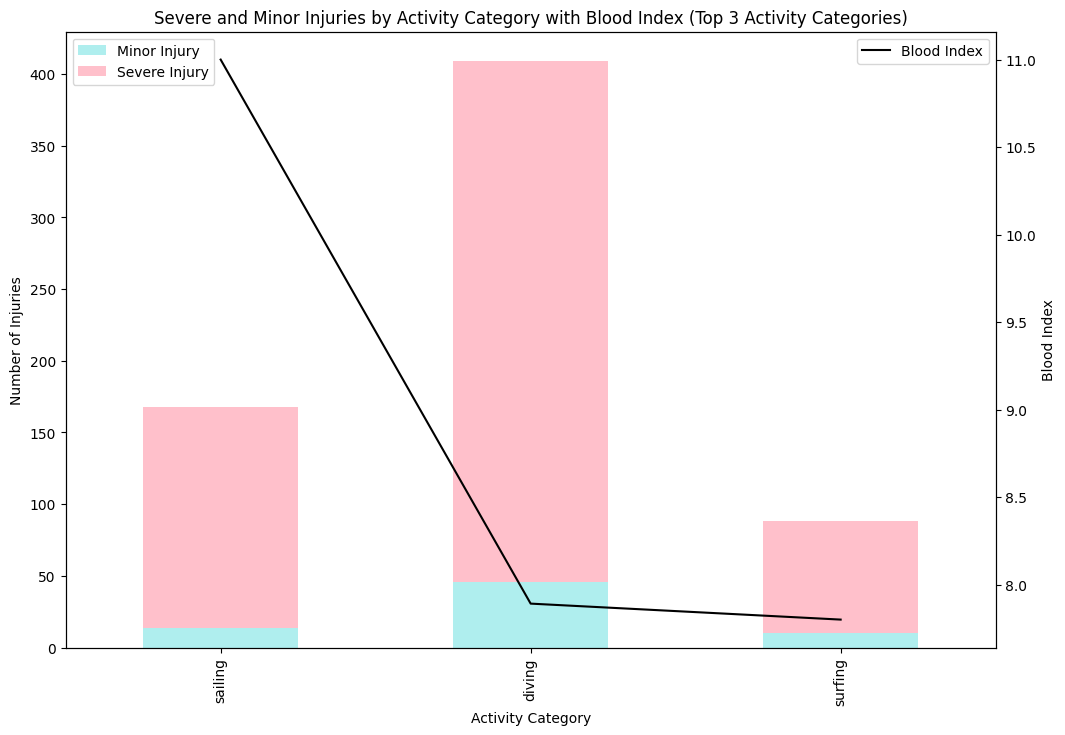

In [52]:
activity_table = get_blood_index("Activity Category")
top_3_activity_categories = activity_table.head(3)

fig, ax1 = plt.subplots(figsize=(12, 8))

top_3_activity_categories.reset_index().plot(kind='bar', x='Activity Category', y='minor injury', ax=ax1, color='paleturquoise', label='Minor Injury')
top_3_activity_categories.reset_index().plot(kind='bar', x='Activity Category', y='severe injury', ax=ax1, color='pink', label='Severe Injury', bottom=top_3_activity_categories['minor injury'])

ax2 = ax1.twinx()
ax2.plot(top_3_activity_categories.index, top_3_activity_categories['blood_index'], label='Blood Index', color='black')

ax1.set_ylabel('Number of Injuries')
ax1.set_title('Severe and Minor Injuries by Activity Category with Blood Index (Top 3 Activity Categories)')
ax2.set_ylabel('Blood Index')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()


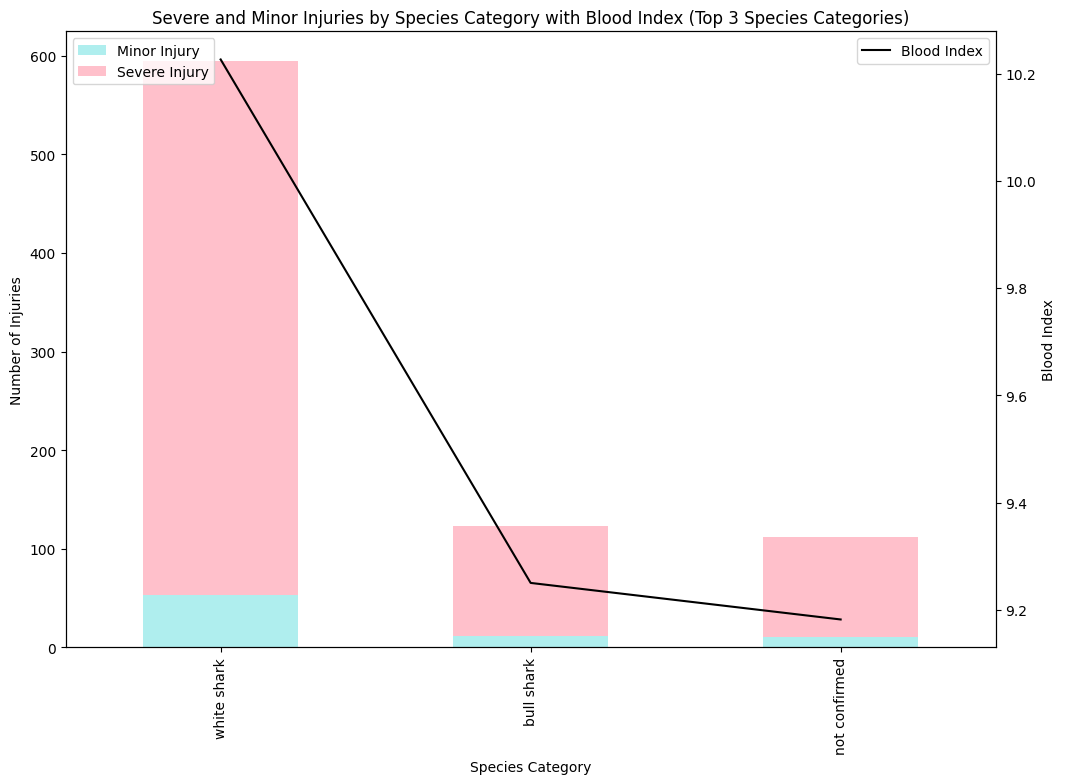

In [54]:
species_table = get_blood_index("Species Category")
top_3_species_categories = species_table.head(3)

fig, ax1 = plt.subplots(figsize=(12, 8))

top_3_species_categories.reset_index().plot(kind='bar', x='Species Category', y='minor injury', ax=ax1, color='paleturquoise', label='Minor Injury')
top_3_species_categories.reset_index().plot(kind='bar', x='Species Category', y='severe injury', ax=ax1, color='pink', label='Severe Injury', bottom=top_3_species_categories['minor injury'])

ax2 = ax1.twinx()
ax2.plot(top_3_species_categories.index, top_3_species_categories['blood_index'], label='Blood Index', color='black')

ax1.set_ylabel('Number of Injuries')
ax1.set_title('Severe and Minor Injuries by Species Category with Blood Index (Top 3 Species Categories)')
ax2.set_ylabel('Blood Index')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

/var/folders/m3/cvmhd4j11f7968wyg9z4qfdr0000gn/T/ipykernel_1133/4016415220.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sex_counts.index, y=sex_counts.values, palette='pastel')


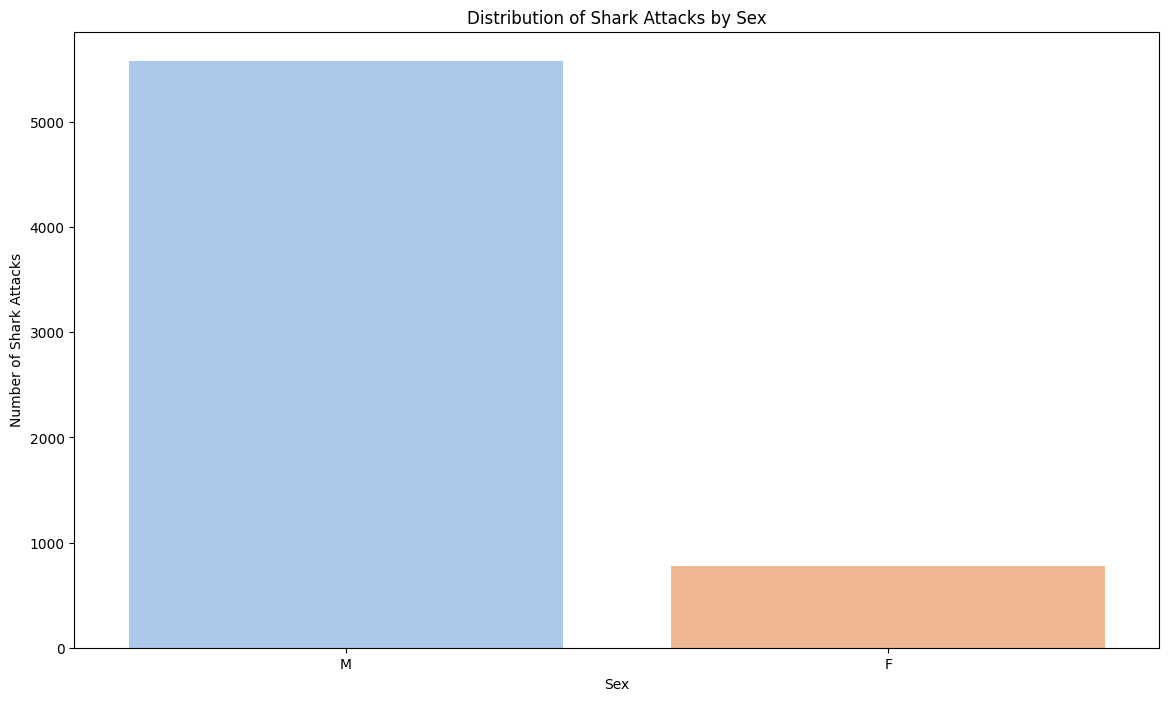

In [72]:
plt.figure(figsize=(14, 8))
sex_counts = shark_data['Sex'].value_counts()
sns.barplot(x=sex_counts.index, y=sex_counts.values, palette='pastel')
plt.title('Distribution of Shark Attacks by Sex')
plt.xlabel('Sex')
plt.ylabel('Number of Shark Attacks')
plt.show()

<Figure size 1400x800 with 0 Axes>

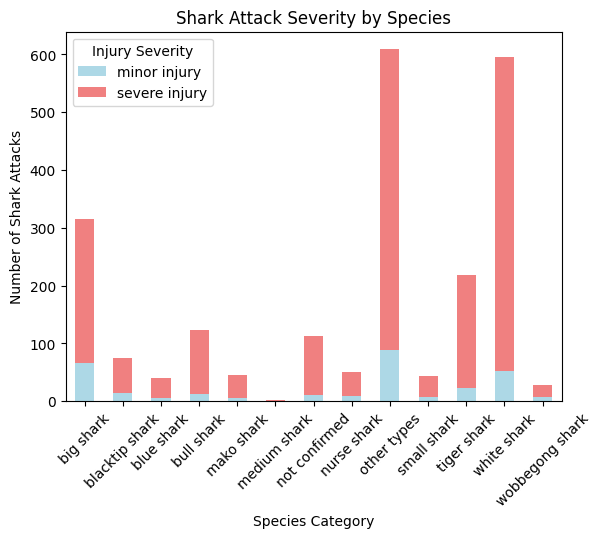

In [74]:
# Comparison of shark attack severity by species
plt.figure(figsize=(14, 8))
species_severity = shark_data.groupby(['Species Category', 'Injury Severity']).size().unstack().fillna(0)
species_severity.plot(kind='bar', stacked=True, color=['lightblue', 'lightcoral'])
plt.title('Shark Attack Severity by Species')
plt.xlabel('Species Category')
plt.ylabel('Number of Shark Attacks')
plt.xticks(rotation=45)
plt.show()